In [1]:
import sys
from contextlib import closing
from io import StringIO
from typing import Optional
import math

import numpy as np

from gym import Env, spaces
from gym.envs.toy_text.utils import categorical_sample

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3


class CliffWalkingEnv(Env):
    """
    MODIFIED VERSION OF: 
    https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py
    
    MODIFICATIONS:
    1. Reward returned is negative distance from new state and goal
    2. Boolean is returned indicating if agent has fallen
    
    DESCRIPTION FROM REFERENCE: 
    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.
    Adapted from Example 6.6 (page 106) from [Reinforcement Learning: An Introduction
    by Sutton and Barto](http://incompleteideas.net/book/bookdraft2018jan1.pdf).
    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py
    ### Description
    The board is a 4x12 matrix, with (using NumPy matrix indexing):
    - [3, 0] as the start at bottom-left
    - [3, 11] as the goal at bottom-right
    - [3, 1..10] as the cliff at bottom-center
    If the agent steps on the cliff it returns to the start.
    An episode terminates when the agent reaches the goal.
    ### Actions
    There are 4 discrete deterministic actions:
    - 0: move up
    - 1: move right
    - 2: move down
    - 3: move left
    ### Observations
    There are 3x12 + 1 possible states. In fact, the agent cannot be at the cliff, nor at the goal (as this results the end of episode). They remain all the positions of the first 3 rows plus the bottom-left cell.
    The observation is simply the current position encoded as [flattened index](https://numpy.org/doc/stable/reference/generated/numpy.unravel_index.html).
    ### Reward
    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward.
    ### Arguments
    ```
    gym.make('CliffWalking-v0')
    ```
    """

    metadata = {"render_modes": ["human", "ansi"], "render_fps": 4}

    def __init__(self):
        self.shape = (4, 12)
        self.start_state_index = np.ravel_multi_index((3, 0), self.shape)

        self.nS = np.prod(self.shape)
        self.nA = 4

        # Cliff Location
        self._cliff = np.zeros(self.shape, dtype=bool)
        self._cliff[3, 1:-1] = True

        # Calculate transition probabilities and rewards
        self.P = {}
        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            self.P[s] = {a: [] for a in range(self.nA)}
            self.P[s][UP] = self._calculate_transition_prob(position, [-1, 0])
            self.P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1])
            self.P[s][DOWN] = self._calculate_transition_prob(position, [1, 0])
            self.P[s][LEFT] = self._calculate_transition_prob(position, [0, -1])

        # Calculate initial state distribution
        # We always start in state (3, 0)
        self.initial_state_distrib = np.zeros(self.nS)
        self.initial_state_distrib[self.start_state_index] = 1.0

        self.observation_space = spaces.Discrete(self.nS)
        self.action_space = spaces.Discrete(self.nA)

    def _limit_coordinates(self, coord):
        """
        Prevent the agent from falling out of the grid world
        :param coord:
        :return:
        """
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta):
        """
        Determine the outcome for an action. Transition Prob is always 1.0.
        :param current: Current position on the grid as (row, col)
        :param delta: Change in position for transition
        :return: (1.0, new_state, reward, done)
        """
        new_position = np.array(current) + np.array(delta)
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        terminal_state = (self.shape[0] - 1, self.shape[1] - 1)
        
        if self._cliff[tuple(new_position)]:
            reward = -12
            return [(1.0, self.start_state_index, reward, False, True)]

        is_done = tuple(new_position) == terminal_state
        reward =  1 if is_done else -1 * math.sqrt((new_position[0] - terminal_state[0])**2 + (new_position[1] - terminal_state[1])**2)
        return [(1.0, new_state, reward, is_done, False)] 

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, d, f = transitions[i]
        self.s = s
        self.lastaction = a
        return (int(s), r, d, f, {"prob": p})

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        return_info: bool = False,
        options: Optional[dict] = None
    ):
        super().reset(seed=seed)
        self.s = categorical_sample(self.initial_state_distrib, self.np_random)
        self.lastaction = None
        if not return_info:
            return int(self.s)
        else:
            return int(self.s), {"prob": 1}

    def render(self, mode="human"):
        outfile = StringIO() if mode == "ansi" else sys.stdout

        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            if self.s == s:
                output = " x "
            # Print terminal state
            elif position == (3, 11):
                output = " T "
            elif self._cliff[position]:
                output = " C "
            else:
                output = " o "

            if position[1] == 0:
                output = output.lstrip()
            if position[1] == self.shape[1] - 1:
                output = output.rstrip()
                output += "\n"

            outfile.write(output)
        outfile.write("\n")

        # No need to return anything for human
        if mode != "human":
            with closing(outfile):
                return outfile.getvalue()

In [2]:
import matplotlib
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards", "episode_falls", "target_reward"])

def plot_average_stats(stats, secondStats):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths, label="Safe Q-learning")
    plt.plot(secondStats.episode_lengths, label="Greedy Q-learning")
    plt.xlabel("Simulation")
    plt.ylabel("Average episode length")
    plt.title("Average episode length per simulation")
    plt.legend(loc="upper right")
    plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    plt.plot(np.arange(len(stats.episode_lengths)), stats.episode_rewards, label="Safe Q-learning")
    plt.plot(np.arange(len(secondStats.episode_lengths)), secondStats.episode_rewards, label="Greedy Q-learning")
    plt.legend(loc="lower right")
    plt.xlabel("Simulation")
    plt.ylabel("Average reward")
    plt.title("Average reward per simulation")
    plt.show(fig2)
        
    # Plot number of falls
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.arange(len(stats.episode_lengths)), stats.episode_falls, label="Safe Q-learning")
    plt.plot(np.arange(len(secondStats.episode_lengths)), secondStats.episode_falls, label="Greedy Q-learning")
    plt.ylabel("Average falls")
    plt.xlabel("Simulation")
    plt.title("Average falls per simulation")
    plt.legend(loc="upper right")
    plt.show(fig3)
        
    # Plot number of falls vs reward
    fig4 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_falls, stats.episode_rewards, label="Safe Q-learning")
    plt.plot(secondStats.episode_falls, secondStats.episode_rewards, label="Greedy Q-learning")
    plt.ylabel("Average reward")
    plt.xlabel("Average falls")
    plt.title("Average falls vs. Average reward")
    plt.legend(loc="upper right")
    plt.show(fig4)
    
    return

def plot_episode_stats(stats, secondStats):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths, label="Safe Q-learning")
    plt.plot(secondStats.episode_lengths, label="Greedy Q-learning")
    plt.xlabel("Episode")
    plt.ylabel("Episode length")
    plt.title("Episode length over time")
    plt.legend(loc="upper right")
    plt.show(fig1)
    
    # Plot the episode length over time
    fig11 = plt.figure(figsize=(10,5))
    plt.plot(np.arange(40, len(stats.episode_lengths)), stats.episode_lengths[40:], label="Safe Q-learning")
    plt.plot(np.arange(40, len(stats.episode_lengths)), secondStats.episode_lengths[40:], label="Greedy Q-learning")
    plt.xlabel("Episode")
    plt.ylabel("Episode length")
    plt.title("Episode length over time for episodes 40 to 100")
    plt.legend(loc="upper right")
    plt.show(fig11)
        
    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    plt.plot(np.arange(len(stats.episode_lengths)), stats.episode_rewards, label="Safe Q-learning")
    plt.plot(np.arange(len(secondStats.episode_lengths)), secondStats.episode_rewards, label="Greedy Q-learning")
    plt.legend(loc="lower right")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Episode reward over time")
    plt.show(fig2)
    
    # Plot the episode reward over time
    fig22 = plt.figure(figsize=(10,5))
    plt.plot(np.arange(40, len(stats.episode_lengths)), stats.episode_rewards[40:], label="Safe Q-learning")
    plt.plot(np.arange(40, len(secondStats.episode_lengths)), secondStats.episode_rewards[40:], label="Greedy Q-learning")
    plt.legend(loc="lower right")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Episode reward over time for episodes 40 to 100")
    plt.show(fig22)
        
    # Plot number of falls
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.arange(len(stats.episode_lengths)), stats.episode_falls, label="Safe Q-learning")
    plt.plot(np.arange(len(secondStats.episode_lengths)), secondStats.episode_falls, label="Greedy Q-learning")
    plt.ylabel("Falls")
    plt.xlabel("Episode")
    plt.title("Falls per episode over time")
    plt.legend(loc="upper right")
    plt.show(fig3)
    
    # Plot number of falls
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_falls), np.cumsum(stats.episode_rewards), label="Safe Q-learning")
    plt.plot(np.cumsum(secondStats.episode_falls), np.cumsum(secondStats.episode_rewards), label="Greedy Q-learning")
    plt.ylabel("Total reward")
    plt.xlabel("Total falls")
    plt.title("Cumulative Sum - Falls vs. Reward")
    plt.legend(loc="upper right")
    plt.show(fig3)
    
    return

def plot_average_stats_subplots(stats, secondStats):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(stats.episode_lengths, label="Safe Q-learning")
    plt.legend(loc="upper right")
    plt.subplot(1, 2, 2)
    plt.plot(secondStats.episode_lengths, c='b', label="Greedy Q-learning")
    plt.xlabel("Simulation")
    plt.ylabel("Average episode length")
    plt.legend(loc="upper right")
    plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(stats.episode_lengths)), stats.episode_rewards, label="Safe Q-learning")
    plt.legend(loc="upper right")
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(secondStats.episode_lengths)), secondStats.episode_rewards, c='b', label="Greedy Q-learning")
    plt.legend(loc="upper right")
    plt.xlabel("Simulation")
    plt.ylabel("Average reward")
    plt.show(fig2)
        
    # Plot number of falls
    fig3 = plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(stats.episode_lengths)), stats.episode_falls, label="Safe Q-learning")
    plt.legend(loc="upper right")
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(secondStats.episode_lengths)), secondStats.episode_falls, c='b', label="Greedy Q-learning")
    plt.ylabel("Average falls")
    plt.xlabel("Simulation")
    plt.legend(loc="upper right")
    plt.show(fig3)
        
    # Plot number of falls vs reward
    fig4 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_falls, stats.episode_rewards, label="Safe Q-learning")
    plt.legend(loc="upper right")
    plt.plot(secondStats.episode_falls, secondStats.episode_rewards, label="Greedy Q-learning")
    plt.ylabel("Average reward")
    plt.xlabel("Average falls")
    plt.legend(loc="upper right")
    plt.show(fig4)
    
    return

In [3]:
import gym
import itertools
import matplotlib
import matplotlib.style
import numpy as np
import pandas as pd
import sys
import random
import math
  
from collections import defaultdict

matplotlib.style.use('ggplot')

env = CliffWalkingEnv()

In [4]:
def createEpsilonGreedyPolicy(Q, epsilon, num_actions):
    """
    Reference: https://www.geeksforgeeks.org/q-learning-in-python/
    """
    def policyFunction(state):
   
        shouldTakeBestAction = random.random() > epsilon
                
        if shouldTakeBestAction:
            return np.argmax(Q[state])
        else:
            return np.random.choice(np.arange(num_actions))
        
    return policyFunction

def safePolicyFunction(Qb, num_actions):
    def policyFunction(state, epsilon):
        
        shouldTakeBestAction = random.random() > epsilon
                
        if shouldTakeBestAction:
            return np.argmax(Qb[state])
        else:
            random_action = np.random.choice(np.arange(num_actions))
            count = 0
            while Qb[state][random_action] < -50 and count <= num_actions * 2:
                random_action = np.random.choice(np.arange(num_actions))
                count = count + 1
            return random_action
                                
    return policyFunction

def targetPolicyFunction(Qt, num_actions):
    def policyFunction(state):
            return np.argmax(Qt[state])
    return policyFunction

In [5]:
def originalQLearning(env, num_episodes, policy, discount_factor = 1, alpha = 0.6, epsilon = 0.1):
    """
    Reference: https://www.geeksforgeeks.org/q-learning-in-python/
    """    
    Q = defaultdict(lambda: np.full(env.action_space.n, -1))

    stats = EpisodeStats(
        episode_lengths = np.zeros(num_episodes),
        episode_rewards = np.zeros(num_episodes),
        episode_falls = np.zeros(num_episodes),
        target_reward = np.zeros(num_episodes)
    )

    policy = policy(Q, epsilon, env.action_space.n)

    # For every episode
    for ith_episode in range(num_episodes):

        state = env.reset()

        for t in itertools.count():

            action = policy(state)
            
            next_state, reward, done, hasFallen, _ = env.step(action)
            
            stats.target_reward[ith_episode] += reward
            stats.episode_rewards[ith_episode] += reward
            stats.episode_lengths[ith_episode] = t
            stats.episode_falls[ith_episode] += 1 if hasFallen else 0

            best_next_action = np.argmax(Q[next_state])
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta

            if done:
                break

            state = next_state

    return Q, stats

In [6]:
def safeQLearning(env, num_episodes, policy, epsilon = 1, discount_factor = 1, alpha = 0.6):        
    # Initialize Qt(s, a) and Qb(s, a)
    Qt = defaultdict(lambda: np.zeros(env.action_space.n)) 
    Qb = defaultdict(lambda: np.zeros(env.action_space.n))

    # Initialize episode statistics
    stats = EpisodeStats(
        episode_lengths = np.zeros(num_episodes),
        episode_rewards = np.zeros(num_episodes), 
        episode_falls = np.zeros(num_episodes),
        target_reward = np.zeros(num_episodes)
    )
    
    policy = policy(Qb, env.action_space.n)

    # Loop for each episode
    for ith_episode in range(num_episodes):

        # Initialize S
        state = env.reset() 
        
        # Initialize epsilon
        epsilon = 0.1

        # Loop for each step of the episode
        for t in itertools.count():

            # Choose A from S using policy
            action = policy(state, epsilon)

            # Perform action A and observe R and S' returned from environment
            next_state, reward, done, hasFallen, _ = env.step(action)
            
            # Modify rewards into Rt and Rb
            Rt = -200 if hasFallen else reward
            Rb = -200 if hasFallen else -1
            
            # Update statistics
            stats.target_reward[ith_episode] += Rt
            stats.episode_rewards[ith_episode] += reward
            stats.episode_lengths[ith_episode] = t
            stats.episode_falls[ith_episode] += 1 if hasFallen else 0

            # TD Update for Qt
            best_next_action = np.argmax(Qt[next_state])
            td_target = Rt + discount_factor * Qt[next_state][best_next_action]
            td_delta = td_target - Qt[state][action]
            Qt[state][action] += alpha * td_delta
            
            # TD Update for Qb
            best_next_action = np.argmax(Qb[next_state])
            td_target = Rb + discount_factor * Qb[next_state][best_next_action]
            td_delta = td_target - Qb[state][action]
            Qb[state][action] += alpha * td_delta

            # If agent reached goal then end the simulation
            if done:
                break

            # Update the state
            state = next_state
            
            # Update epsilon
            epsilon = epsilon * (1 - 1 / num_episodes)

    return Qt, stats

In [7]:
def testQLearning(env, num_episodes, policy, Qt, discount_factor = 1, alpha = 0.6):
    # Initialize episode statistics
    stats = EpisodeStats(
        episode_lengths = np.zeros(num_episodes),
        episode_rewards = np.zeros(num_episodes), 
        episode_falls = np.zeros(num_episodes),
        target_reward = np.zeros(num_episodes)
    )
    
    policy = policy(Qt, env.action_space.n)

    # Loop for each episode
    for ith_episode in range(num_episodes):

        # Initialize S
        state = env.reset() 

        # Loop for each step of the episode
        for t in itertools.count():
            if(t > 1000):
                break
            # Choose A from S using policy
            action = policy(state)

            # Perform action A and observe R and S' returned from environment
            next_state, reward, done, hasFallen, _ = env.step(action)
            
            # Update statistics
            stats.target_reward[ith_episode] += reward
            stats.episode_rewards[ith_episode] += reward
            stats.episode_lengths[ith_episode] = t
            stats.episode_falls[ith_episode] += 1 if hasFallen else 0

            # If agent reached goal then end the simulation
            if done:
                break

            # Update the state
            state = next_state

    return Qt, stats

In [8]:
def getEpisodeStatsWithArrays():
    return EpisodeStats(
        episode_lengths = [],
        episode_rewards = [], 
        episode_falls = [],
        target_reward = []
    )

def getEpisodeStatsWithZeroes(number):
    return EpisodeStats(
        episode_lengths = np.zeros(number),
        episode_rewards = np.zeros(number), 
        episode_falls = np.zeros(number),
        target_reward = np.zeros(number)
    )

def appendValuesToArray(array, values):
    array.episode_lengths.append(values.episode_lengths)
    array.episode_rewards.append(values.episode_rewards)
    array.episode_falls.append(values.episode_falls)
    array.target_reward.append(values.target_reward)
    
def appendLastValuesToArray(array, values):
    array.episode_lengths.append(values.episode_lengths[49:])
    array.episode_rewards.append(values.episode_rewards[49:])
    array.episode_falls.append(values.episode_falls[49:])
    array.target_reward.append(values.target_reward[49:])
    
def calculateAverageOfArray(array, values):
    for i in range(len(values.episode_lengths)):
        array.episode_lengths[i] = np.average(values.episode_lengths[i])
        array.episode_rewards[i] = np.average(values.episode_rewards[i])
        array.episode_falls[i] = np.average(values.episode_falls[i])
        array.target_reward[i] = np.average(values.target_reward[i])
        
def appendValuesToEpisode(array, values):
    return EpisodeStats(np.add(array.episode_lengths, values.episode_lengths),
                        np.add(array.episode_rewards, values.episode_rewards),
                        np.add(array.episode_falls, values.episode_falls),
                        np.add(array.target_reward, values.target_reward)

            )
  
def calculateAverageOfTimestep(array, num_episodes, num_sim):
    for i in range(num_episodes):
        array.episode_lengths[i] = array.episode_lengths[i] / num_sim
        array.episode_rewards[i] = array.episode_rewards[i] / num_sim
        array.episode_falls[i] = array.episode_falls[i] / num_sim
        array.target_reward[i] = array.target_reward[i] / num_sim

In [9]:
def printStatistics(average_safe_statistics, average_greedy_statistics,): 
    print("Episode length")
    print("Average: [GREEDY] " + str(np.average(average_greedy_statistics.episode_lengths)) + " [SAFE] " + str(np.average(average_safe_statistics.episode_lengths)))
    print("Variance: [GREEDY] " + str(np.var(average_greedy_statistics.episode_lengths)) + " [SAFE] " + str(np.var(average_safe_statistics.episode_lengths)))
    
    print("\nTotal reward")
    print("Average: [GREEDY] " + str(np.average(average_greedy_statistics.episode_rewards)) + " [SAFE] " + str(np.average(average_safe_statistics.episode_rewards)))
    print("Variance: [GREEDY] " + str(np.var(average_greedy_statistics.episode_rewards)) + " [SAFE] " + str(np.var(average_safe_statistics.episode_rewards)))
    
    print("\nNumber of falls")
    print("Average: [GREEDY] " + str(np.average(average_greedy_statistics.episode_falls)) + " [SAFE] " + str(np.average(average_safe_statistics.episode_falls)))
    print("Variance: [GREEDY] " + str(np.var(average_greedy_statistics.episode_falls)) + " [SAFE] " + str(np.var(average_safe_statistics.episode_falls)))

In [10]:
def trainModel(): 
    num_sim = 100
    num_episodes = 100
    safeQTables = []
    greedyQTables = []

    safe_statistics = getEpisodeStatsWithArrays()
    greedy_statistics = getEpisodeStatsWithArrays()

    average_safe_statistics = getEpisodeStatsWithZeroes(num_sim)
    average_greedy_statistics = getEpisodeStatsWithZeroes(num_sim)

    time_step_safe = getEpisodeStatsWithZeroes(num_episodes)
    time_step_greedy = getEpisodeStatsWithZeroes(num_episodes)

    for i in range(num_sim):
        Qt, stats = safeQLearning(env, num_episodes, safePolicyFunction)
        Qe, eStats = originalQLearning(env, num_episodes, createEpsilonGreedyPolicy)
        safeQTables.append(Qt)
        greedyQTables.append(Qe)

        appendLastValuesToArray(safe_statistics, stats)
        appendLastValuesToArray(greedy_statistics, eStats)

        time_step_safe = appendValuesToEpisode(time_step_safe, stats)
        time_step_greedy = appendValuesToEpisode(time_step_greedy, eStats)

    calculateAverageOfArray(average_safe_statistics, safe_statistics)
    calculateAverageOfArray(average_greedy_statistics, greedy_statistics)

    calculateAverageOfTimestep(time_step_safe, num_episodes, num_sim)
    calculateAverageOfTimestep(time_step_greedy, num_episodes, num_sim)

    plot_episode_stats(time_step_safe, time_step_greedy)
    plot_average_stats(average_safe_statistics, average_greedy_statistics)
    
    printStatistics(average_safe_statistics, average_greedy_statistics)
    
    return safeQTables, greedyQTables

In [11]:
def testModel(safeQTables, greedyQTables):
    num_episodes = 1
    num_sim = 100
    
    safe_statistics = getEpisodeStatsWithArrays()
    greedy_statistics = getEpisodeStatsWithArrays()
    
    average_safe_statistics = getEpisodeStatsWithZeroes(num_sim)
    average_greedy_statistics = getEpisodeStatsWithZeroes(num_sim)
    
    for i in range(num_sim):
        Qt, stats = testQLearning(env, num_episodes, targetPolicyFunction, safeQTables[i])
        Qe, eStats = testQLearning(env, num_episodes, targetPolicyFunction, greedyQTables[i])
        
        appendValuesToArray(safe_statistics, stats)
        appendValuesToArray(greedy_statistics, eStats)
    
    calculateAverageOfArray(average_safe_statistics, safe_statistics)
    calculateAverageOfArray(average_greedy_statistics, greedy_statistics)

    plot_average_stats_subplots(average_safe_statistics, average_greedy_statistics)
    printStatistics(average_safe_statistics, average_greedy_statistics)

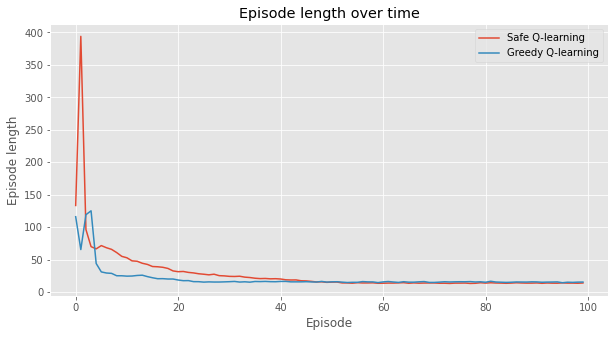

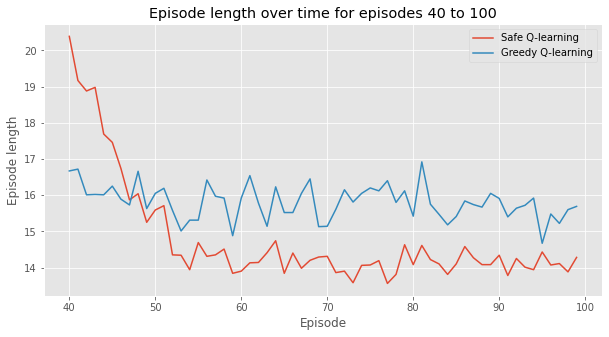

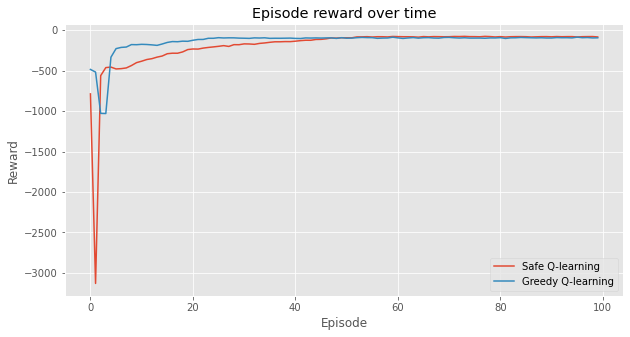

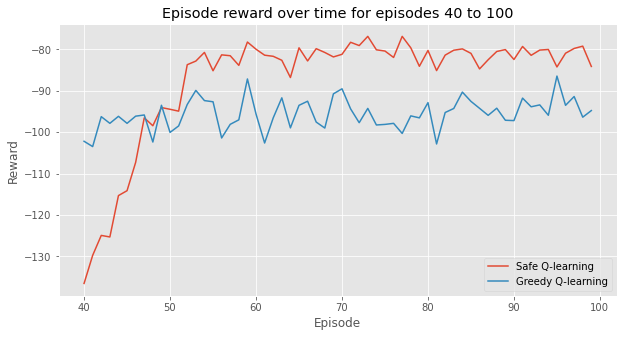

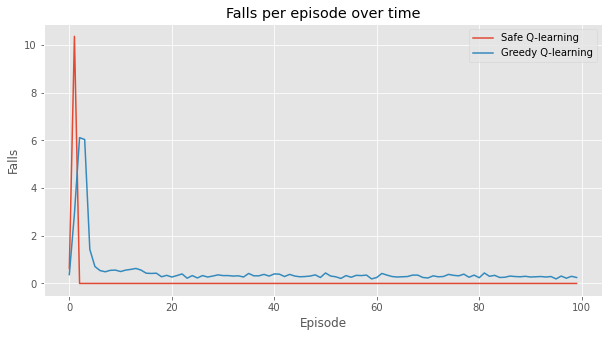

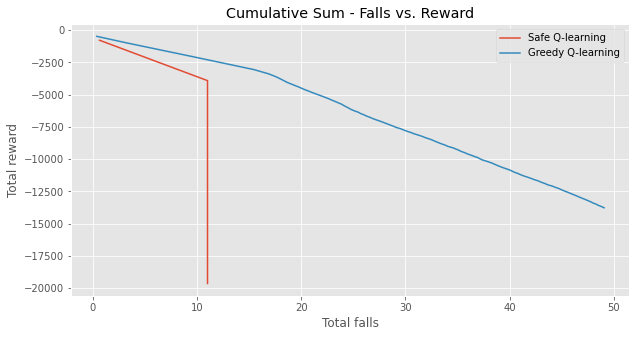

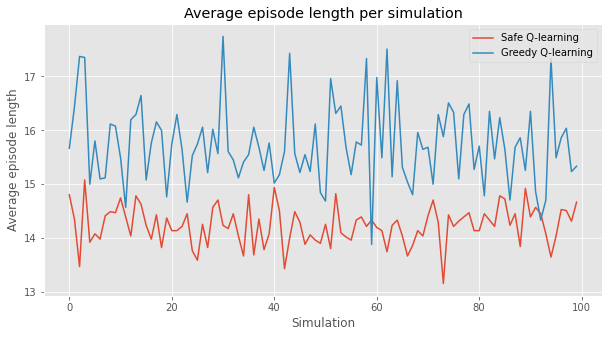

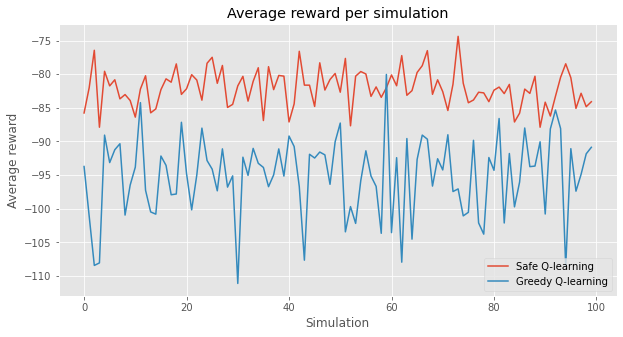

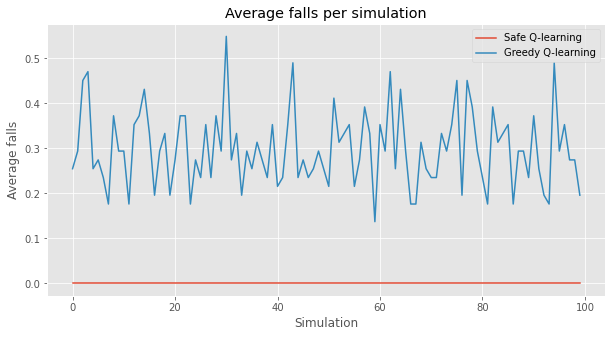

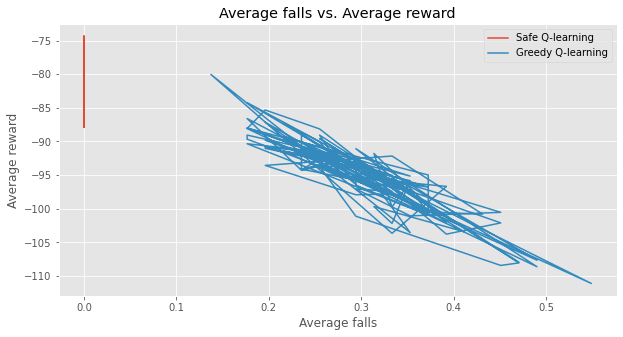

Episode length
Average: [GREEDY] 15.738235294117647 [SAFE] 14.233333333333333
Variance: [GREEDY] 0.5543435217224143 [SAFE] 0.12520184544406004

Total reward
Average: [GREEDY] -95.11046029773026 [SAFE] -82.0494343356941
Variance: [GREEDY] 33.919125107995576 [SAFE] 7.423350346455051

Number of falls
Average: [GREEDY] 0.2986274509803921 [SAFE] 0.0
Variance: [GREEDY] 0.007019261822376008 [SAFE] 0.0


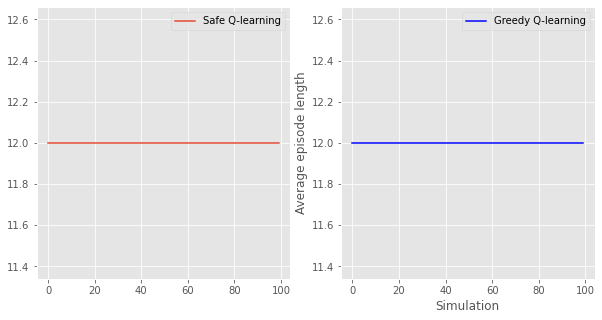

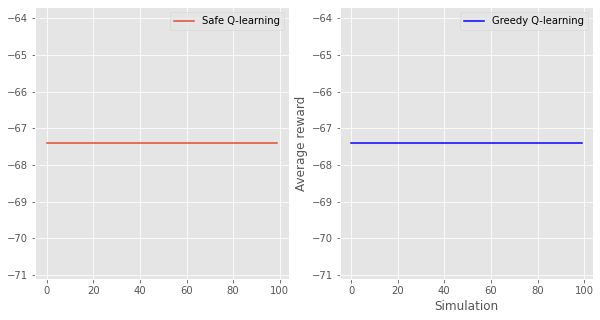

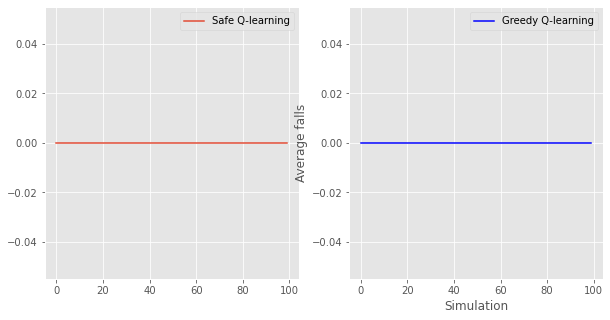

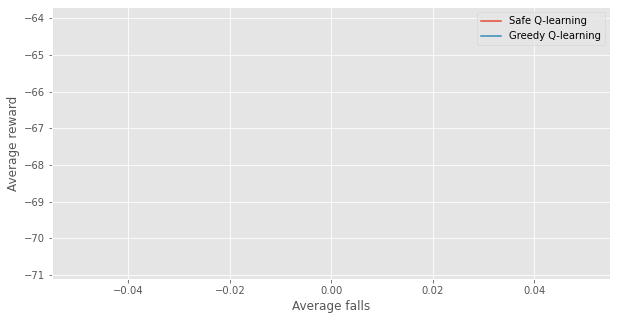

Episode length
Average: [GREEDY] 12.0 [SAFE] 12.0
Variance: [GREEDY] 0.0 [SAFE] 0.0

Total reward
Average: [GREEDY] -67.4013942061595 [SAFE] -67.4013942061595
Variance: [GREEDY] 8.077935669463161e-28 [SAFE] 8.077935669463161e-28

Number of falls
Average: [GREEDY] 0.0 [SAFE] 0.0
Variance: [GREEDY] 0.0 [SAFE] 0.0


In [12]:
safeQTables, greedyQTables = trainModel()
testModel(safeQTables, greedyQTables)